# Bygg en klassificeringsmodell: Utsökta asiatiska och indiska rätter


## Klassificering av kök 1

I den här lektionen ska vi utforska olika klassificeringsmetoder för att *förutsäga ett visst nationellt kök baserat på en grupp ingredienser.* Samtidigt kommer vi att lära oss mer om hur algoritmer kan användas för klassificeringsuppgifter.

### [**Quiz före lektionen**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Förberedelse**

Den här lektionen bygger vidare på vår [föregående lektion](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) där vi:

-   Gjorde en mjuk introduktion till klassificeringar med hjälp av en dataset om alla fantastiska kök från Asien och Indien 😋.

-   Utforskade några [dplyr-verb](https://dplyr.tidyverse.org/) för att förbereda och städa vår data.

-   Skapade vackra visualiseringar med ggplot2.

-   Visade hur man hanterar obalanserad data genom att förbehandla den med [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Demonstrerade hur man `prep` och `bake` vår recipe för att säkerställa att den fungerar som den ska.

#### **Förkunskaper**

För den här lektionen behöver vi följande paket för att städa, förbereda och visualisera vår data:

-   `tidyverse`: [tidyverse](https://www.tidyverse.org/) är en [samling av R-paket](https://www.tidyverse.org/packages) som är utformade för att göra datavetenskap snabbare, enklare och roligare!

-   `tidymodels`: [tidymodels](https://www.tidymodels.org/) är ett [ramverk av paket](https://www.tidymodels.org/packages/) för modellering och maskininlärning.

-   `themis`: [themis-paketet](https://themis.tidymodels.org/) erbjuder extra steg för att hantera obalanserad data.

-   `nnet`: [nnet-paketet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) tillhandahåller funktioner för att uppskatta feed-forward neurala nätverk med ett enda dolt lager, samt för multinomiala logistiska regressionsmodeller.

Du kan installera dem som:


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativt kontrollerar skriptet nedan om du har de paket som krävs för att slutföra denna modul och installerar dem åt dig om de saknas.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Dela upp data i tränings- och testuppsättningar.

Vi börjar med att välja några steg från vår tidigare lektion.

### Ta bort de vanligaste ingredienserna som skapar förvirring mellan olika kök, med hjälp av `dplyr::select()`.

Alla älskar ris, vitlök och ingefära!


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Perfekt! Nu är det dags att dela upp datan så att 70 % går till träning och 30 % till testning. Vi kommer också att använda en `stratifieringsteknik` vid uppdelningen för att `behålla proportionen av varje kök` i tränings- och valideringsdatan.

[rsample](https://rsample.tidymodels.org/), ett paket i Tidymodels, erbjuder infrastruktur för effektiv datauppdelning och resampling:


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Hantera obalanserad data

Som du kanske har märkt i den ursprungliga datamängden såväl som i vår träningsuppsättning, finns det en ganska ojämn fördelning i antalet kök. Koreanska kök är *nästan* tre gånger fler än thailändska kök. Obalanserad data har ofta negativa effekter på modellens prestanda. Många modeller fungerar bäst när antalet observationer är lika och har därför svårt att hantera obalanserad data.

Det finns huvudsakligen två sätt att hantera obalanserade datamängder:

-   lägga till observationer till minoritetsklassen: `Över-sampling`, t.ex. med en SMOTE-algoritm som syntetiskt genererar nya exempel för minoritetsklassen med hjälp av närmaste grannar till dessa fall.

-   ta bort observationer från majoritetsklassen: `Under-sampling`

I vår tidigare lektion visade vi hur man hanterar obalanserade datamängder med hjälp av ett `recept`. Ett recept kan ses som en ritning som beskriver vilka steg som ska tillämpas på en datamängd för att göra den redo för dataanalys. I vårt fall vill vi ha en jämn fördelning av antalet kök i vår `träningsuppsättning`. Låt oss sätta igång direkt.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Du kan självklart gå vidare och bekräfta (genom att förbereda och baka) att receptet fungerar som du förväntar dig - alla kökskategorier har `559` observationer.

Eftersom vi kommer att använda detta recept som en förprocessor för modellering, kommer en `workflow()` att hantera all förberedelse och bakning åt oss, så vi behöver inte manuellt uppskatta receptet.

Nu är vi redo att träna en modell 👩‍💻👨‍💻!

## 3. Välja din klassificerare

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Konstverk av @allison_horst</figcaption>


Nu måste vi bestämma vilken algoritm vi ska använda för uppgiften 🤔.

I Tidymodels erbjuder [`parsnip-paketet`](https://parsnip.tidymodels.org/index.html) ett konsekvent gränssnitt för att arbeta med modeller över olika motorer (paket). Se gärna dokumentationen för parsnip för att utforska [modelltyper och motorer](https://www.tidymodels.org/find/parsnip/#models) samt deras motsvarande [modellargument](https://www.tidymodels.org/find/parsnip/#model-args). Utbudet kan verka överväldigande vid första anblicken. Till exempel inkluderar följande metoder alla klassificeringstekniker:

-   C5.0 Regelbaserade klassificeringsmodeller

-   Flexibla diskriminantmodeller

-   Linjära diskriminantmodeller

-   Regulariserade diskriminantmodeller

-   Logistiska regressionsmodeller

-   Multinomiala regressionsmodeller

-   Naiva Bayes-modeller

-   Supportvektormaskiner

-   Närmaste grannar

-   Beslutsträd

-   Ensemblemetoder

-   Neurala nätverk

Listan fortsätter!

### **Vilken klassificerare ska man välja?**

Så, vilken klassificerare ska du välja? Ofta är det en bra idé att testa flera och leta efter ett bra resultat.

> AutoML löser detta problem smidigt genom att köra dessa jämförelser i molnet, vilket gör att du kan välja den bästa algoritmen för dina data. Prova det [här](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Valet av klassificerare beror också på vårt problem. Till exempel, när resultatet kan kategoriseras i `fler än två klasser`, som i vårt fall, måste du använda en `multiklassklassificeringsalgoritm` istället för `binär klassificering.`

### **En bättre metod**

En bättre metod än att gissa vilt är att följa idéerna i detta nedladdningsbara [ML Cheat Sheet](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Här upptäcker vi att, för vårt multiklassproblem, har vi några alternativ:

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>En del av Microsofts algoritm-översikt, som beskriver alternativ för multiklassklassificering</figcaption>


### **Resonemang**

Låt oss se om vi kan resonera oss fram till olika tillvägagångssätt med de begränsningar vi har:

-   **Djupa neurala nätverk är för tunga**. Med tanke på vårt rena, men minimala dataset, och det faktum att vi kör träningen lokalt via notebooks, är djupa neurala nätverk för resurskrävande för denna uppgift.

-   **Ingen tvåklassklassificerare**. Vi använder inte en tvåklassklassificerare, vilket utesluter one-vs-all.

-   **Beslutsträd eller logistisk regression kan fungera**. Ett beslutsträd kan fungera, eller multinomial regression/multiklass logistisk regression för multiklassdata.

-   **Multiklass Boosted Decision Trees löser ett annat problem**. Multiklass Boosted Decision Trees är mest lämpliga för icke-parametriska uppgifter, t.ex. uppgifter som är utformade för att skapa rankningar, så de är inte användbara för oss.

Dessutom, innan man vanligtvis ger sig in på mer komplexa maskininlärningsmodeller, t.ex. ensemblemetoder, är det en bra idé att bygga den enklaste möjliga modellen för att få en uppfattning om vad som händer. Så för denna lektion börjar vi med en `multinomial regression`-modell.

> Logistisk regression är en teknik som används när utfallsvariabeln är kategorisk (eller nominell). För binär logistisk regression är antalet utfallsvariabler två, medan antalet utfallsvariabler för multinomial logistisk regression är fler än två. Se [Avancerade regressionsmetoder](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) för vidare läsning.

## 4. Träna och utvärdera en multinomial logistisk regressionsmodell.

I Tidymodels definierar `parsnip::multinom_reg()` en modell som använder linjära prediktorer för att förutsäga multiklassdata med hjälp av multinomialfördelningen. Se `?multinom_reg()` för de olika sätt/engines du kan använda för att passa denna modell.

För detta exempel kommer vi att passa en multinomial regressionsmodell via den förvalda [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf)-motorn.

> Jag valde ett värde för `penalty` lite slumpmässigt. Det finns bättre sätt att välja detta värde, nämligen genom att använda `resampling` och `tuning` av modellen, vilket vi kommer att diskutera senare.
>
> Se [Tidymodels: Kom igång](https://www.tidymodels.org/start/tuning/) om du vill lära dig mer om hur man finjusterar modellens hyperparametrar.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Bra jobbat 🥳! Nu när vi har ett recept och en modellspecifikation behöver vi hitta ett sätt att kombinera dem till ett objekt som först förbehandlar data, sedan anpassar modellen på den förbehandlade datan och även möjliggör potentiella efterbehandlingsaktiviteter. I Tidymodels kallas detta praktiska objekt för en [`workflow`](https://workflows.tidymodels.org/) och håller smidigt dina modellkomponenter! Detta är vad vi skulle kalla *pipelines* i *Python*.

Så låt oss samla allt i en workflow!📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Arbetsflöden 👌👌! En **`workflow()`** kan anpassas på ungefär samma sätt som en modell kan. Så, dags att träna en modell!


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Utdata visar de koefficienter som modellen lärde sig under träningen.

### Utvärdera den tränade modellen

Det är dags att se hur modellen presterade 📏 genom att utvärdera den på en testuppsättning! Låt oss börja med att göra förutsägelser på testuppsättningen.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Bra jobbat! I Tidymodels kan utvärdering av modellprestanda göras med [yardstick](https://yardstick.tidymodels.org/) - ett paket som används för att mäta modellers effektivitet med hjälp av prestandamått. Som vi gjorde i vår lektion om logistisk regression, låt oss börja med att beräkna en förväxlingsmatris.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

När man arbetar med flera klasser är det generellt mer intuitivt att visualisera detta som en värmekarta, så här:


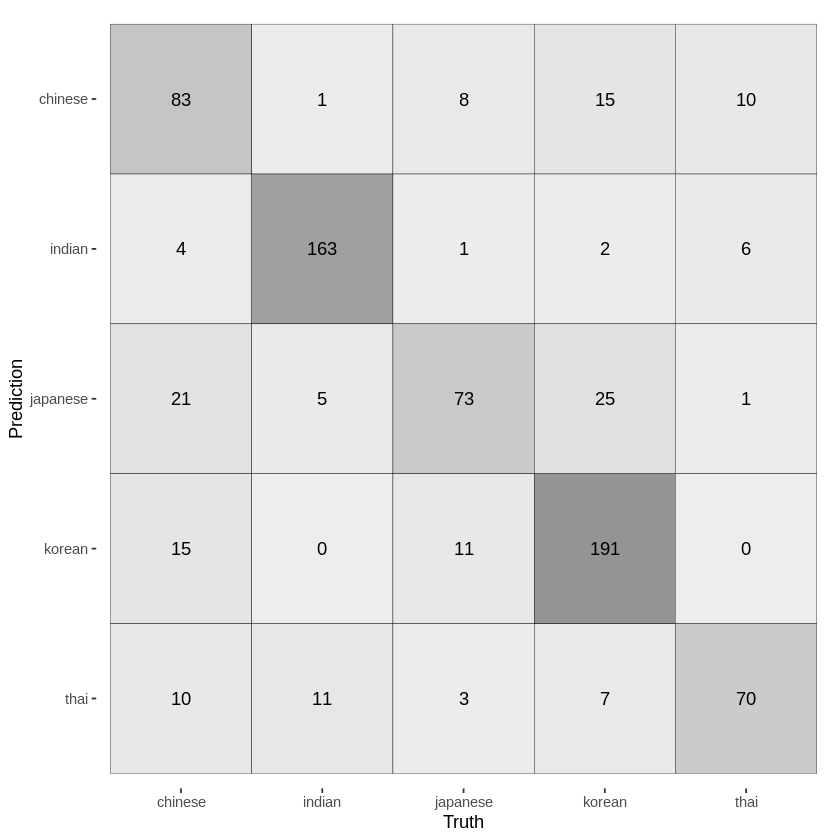

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

De mörkare rutorna i förvirringsmatrisens diagram indikerar ett högt antal fall, och förhoppningsvis kan du se en diagonal linje av mörkare rutor som visar fall där den förutspådda och faktiska etiketten är densamma.

Låt oss nu beräkna sammanfattande statistik för förvirringsmatrisen.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Om vi fokuserar på några mått som noggrannhet, sensitivitet, ppv, så är vi inte helt fel ute för en början 🥳!

## 4. Gå Djupare

Låt oss ställa en subtil fråga: Vilka kriterier används för att välja en viss typ av kök som det förutspådda resultatet?

Statistiska maskininlärningsalgoritmer, som logistisk regression, baseras på `sannolikhet`; så det som faktiskt förutspås av en klassificerare är en sannolikhetsfördelning över en uppsättning möjliga utfall. Klassen med högst sannolikhet väljs sedan som det mest sannolika resultatet för de givna observationerna.

Låt oss se detta i praktiken genom att göra både hårda klassförutsägelser och sannolikheter.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Kan du förklara varför modellen är ganska säker på att den första observationen är thailändsk?

## **🚀Utmaning**

I den här lektionen använde du dina rensade data för att bygga en maskininlärningsmodell som kan förutsäga ett nationellt kök baserat på en serie ingredienser. Ta dig tid att läsa igenom de [många alternativen](https://www.tidymodels.org/find/parsnip/#models) som Tidymodels erbjuder för att klassificera data och [andra sätt](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) att anpassa multinomial regression.

#### TACK TILL:

[`Allison Horst`](https://twitter.com/allison_horst/) för att ha skapat de fantastiska illustrationerna som gör R mer välkomnande och engagerande. Hitta fler illustrationer i hennes [galleri](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) och [Jen Looper](https://www.twitter.com/jenlooper) för att ha skapat den ursprungliga Python-versionen av denna modul ♥️

<br>
Skulle ha slängt in några skämt, men jag fattar inte matvitsar 😅.

<br>

Lycka till med lärandet,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Ansvarsfriskrivning**:  
Detta dokument har översatts med hjälp av AI-översättningstjänsten [Co-op Translator](https://github.com/Azure/co-op-translator). Även om vi strävar efter noggrannhet, vänligen notera att automatiska översättningar kan innehålla fel eller felaktigheter. Det ursprungliga dokumentet på dess originalspråk bör betraktas som den auktoritativa källan. För kritisk information rekommenderas professionell mänsklig översättning. Vi ansvarar inte för eventuella missförstånd eller feltolkningar som uppstår vid användning av denna översättning.
